In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import torchvision.datasets as dsets
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os,sys
from FGSM import fgsm,fgsm_graybox
from train_mnist_model import Net
from tqdm import tqdm
from torch.distributions.categorical import Categorical

homedir = '/home/nikhil/research/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
# homedir = '/home/serge/Documents/Classes/Adversarial_ML/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
MODULE_PATH = ['{}BNN_Implementations/PyTorch-BayesianCNN-master'.format(homedir),
          '{}BNN_Implementations/PyTorch-BayesianCNN-master/models/BayesianModels'.format(homedir)]

for m in MODULE_PATH:
    sys.path.append(m)

import data
from BayesianLeNet import BBBLeNet
import metrics
from utils import *
from models.NonBayesianModels.LeNet import LeNet

In [2]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=0

In [3]:
# dataset = 'MNIST'
# dataset = 'FashionMNIST'
dataset = 'CIFAR10'
net = 'alexnet'
# net = 'lenet'

batch_size=1000
valid_size = 0.2 # will not be used 
num_workers = 0

trainset, testset, inputs, outputs = data.getDataset(dataset)
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, valid_size, 
                                                             batch_size, num_workers)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def bayes_marginalization(net, inputs, J=10):
    
    outputs = torch.zeros(inputs.shape[0], net.num_classes, J).to(device)
    kl = 0.0

    for j in range(J):
        net_out, _kl = net(inputs)
        kl += _kl
        outputs[:, :, j] = F.log_softmax(net_out, dim=1).data
    
    log_outputs = logmeanexp(outputs, dim=2)
    return log_outputs, kl

def bayes_evaluation(net, criterion, validloader, num_ens=100):
    """Calculate ensemble accuracy and NLL Loss"""

    net.train(True)
    
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
                
        log_outputs, kl = bayes_marginalization(net, inputs, num_ens)
        valid_loss += criterion(log_outputs, labels, kl).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def frequentist_evaluation(net, criterion, valid_loader):
    
    valid_loss = 0.0
    accs = []
    net.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(metrics.acc(output.data, target))

    return valid_loss, accs

In [5]:
def attack_fgsm(model,loss,eps,device,loader,is_bayes=False):
    original_preds_soft = []
    attack_preds_soft = []
    
    for batch_idx, (images, labels) in enumerate(loader):
        
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps,is_bayes=is_bayes)
        
        if is_bayes:
            original_preds_soft.append(model(images.to(device))[0].detach())
            attack_preds_soft.append(model(attack_images)[0].detach())
        else:
            original_preds_soft.append(model(images.to(device)).detach())
            attack_preds_soft.append(model(attack_images).detach())
        
    original_preds_soft = torch.cat(original_preds_soft, dim=0)
    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    original_preds = torch.argmax(original_preds_soft,axis=1)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)
    
    success_rate = torch.mean((original_preds!=attack_preds).type(torch.DoubleTensor)).cpu().detach().numpy()
    entropy = np.mean(Categorical(probs = F.softmax(attack_preds_soft,dim=0)).entropy().cpu().detach().numpy())
    
    return success_rate,entropy

In [6]:
def attack_fgsm_v2 (model,loss,eps,device,loader,is_bayes=False):
    
    attack_preds_soft = []
    attack_acc = []
    
    for batch_idx, (images, labels) in enumerate(loader):
        
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps,is_bayes=is_bayes)
        
        if is_bayes:
            log_outputs, _ = bayes_marginalization(model, attack_images, J=100)
            attack_preds_soft.append(log_outputs)
            attack_acc.append(metrics.acc(log_outputs, labels))
        else:
            outputs = model(attack_images).detach()
            attack_preds_soft.append(outputs)
            attack_acc.append(metrics.acc(outputs, labels))

    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)

    if is_bayes:
        entropy = np.mean(Categorical(probs = torch.exp(attack_preds_soft)).entropy().cpu().detach().numpy())
    else:
        entropy = np.mean(Categorical(probs = F.softmax(attack_preds_soft,dim=0)).entropy().cpu().detach().numpy())
    
    return np.mean(attack_acc), entropy, attack_images, images


# Example attack on a non-Bayes CNN (MNIST)

In [7]:
dataset, inputs, outputs

('CIFAR10', 3, 10)

In [8]:
from main_frequentist import getModel
model = getModel(net, inputs, outputs)

In [9]:
# model = LeNet(num_classes=10,inputs=inputs)
ckpt_path = '../../BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/{}/frequentist/model_{}.pt'.format(dataset, net)
model.load_state_dict(torch.load(ckpt_path))
model.eval()
device = torch.device('cuda:0')
model.to(device)
loss = nn.CrossEntropyLoss()

In [10]:
original_loss, original_acc = frequentist_evaluation(model, loss, test_loader)

In [11]:
print (np.mean(original_acc))

0.6686000000000001


In [12]:
if dataset == 'CIFAR10':
    epsilons = np.linspace(0,0.1,40)
else:
    epsilons = np.linspace(0,0.5,20)
    
acc = []
entropies = []
for eps in tqdm(epsilons):
    success_rate,entropy, _, _ = attack_fgsm_v2(model,loss,eps,device,test_loader)
    acc.append(success_rate)
    entropies.append(entropy)

100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


Text(0, 0.5, 'Average predictive entropy')

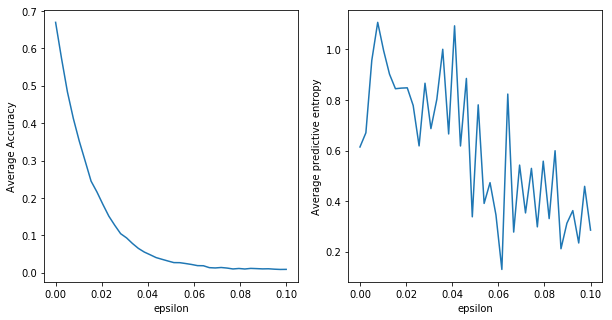

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc)
plt.xlabel('epsilon')
plt.ylabel('Average Accuracy')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Example attack on BayesNet

In [14]:
from main_bayesian import getModel
model = getModel(net, inputs, outputs)

In [15]:
# model = BBBLeNet(outputs=10,inputs=inputs)

ckpt_path = 'BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/{}/bayesian'.format(dataset)
ckpt_name = 'model_{}.pt'.format(net)
model.load_state_dict(torch.load(os.path.join(homedir,ckpt_path,ckpt_name)))
device = torch.device('cuda:0')
model.to(device)
loss = metrics.ELBO(len(test_loader.dataset)).to(device)

In [16]:
# model.train(True) => for sampling
model.training

True

In [17]:
original_loss, original_acc =  bayes_evaluation(model, loss, test_loader)

/media/bigguy/nm208/torch3/lib/python3.5/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [18]:
print (np.mean(original_acc))

0.676


In [19]:
np.linspace(0, 0.1, 20), dataset

(array([0.        , 0.00526316, 0.01052632, 0.01578947, 0.02105263,
        0.02631579, 0.03157895, 0.03684211, 0.04210526, 0.04736842,
        0.05263158, 0.05789474, 0.06315789, 0.06842105, 0.07368421,
        0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ]),
 'CIFAR10')

In [20]:
if dataset == 'CIFAR10':
    epsilons = np.linspace(0,0.1,40)
else:
    epsilons = np.linspace(0,0.5,20)
    
acc_bayes = []
entropies_bayes = []
indices = np.random.choice(len(test_loader), 10)

attack_images_arr = []
original_images_arr = []

for eps in tqdm(epsilons):
    success_rate, entropy, attack_images, original_images = attack_fgsm_v2(model,loss,eps,device,test_loader,is_bayes=True)
    
    attack_images_arr.append(attack_images[indices].cpu().data)
    original_images_arr.append(original_images[indices].cpu().data)
    
    acc_bayes.append(success_rate)
    entropies_bayes.append(entropy)

100%|██████████| 40/40 [12:37<00:00, 18.93s/it]


In [21]:
print (epsilons)

[0.         0.0025641  0.00512821 0.00769231 0.01025641 0.01282051
 0.01538462 0.01794872 0.02051282 0.02307692 0.02564103 0.02820513
 0.03076923 0.03333333 0.03589744 0.03846154 0.04102564 0.04358974
 0.04615385 0.04871795 0.05128205 0.05384615 0.05641026 0.05897436
 0.06153846 0.06410256 0.06666667 0.06923077 0.07179487 0.07435897
 0.07692308 0.07948718 0.08205128 0.08461538 0.08717949 0.08974359
 0.09230769 0.09487179 0.0974359  0.1       ]


In [22]:
print (len(attack_images_arr), len(original_images_arr))

40 40


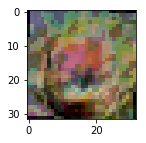

In [23]:
img = attack_images_arr[-1][4]
fig = plt.figure(figsize=(2,2))
plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')

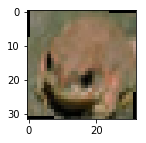

In [24]:
img = original_images_arr[-1][4]
fig = plt.figure(figsize=(2,2))
plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')

Text(0, 0.5, 'Average predictive entropy')

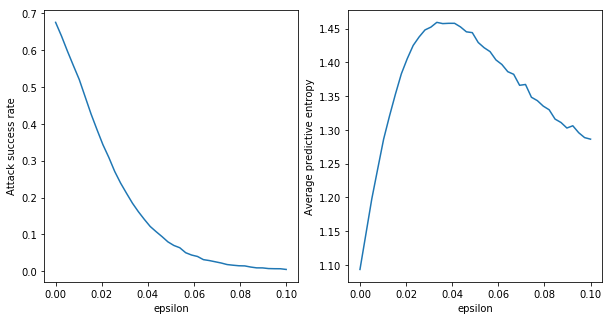

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc_bayes)
plt.xlabel('epsilon')
plt.ylabel('Attack success rate')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies_bayes)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Compare Bayes vs. non-Bayes

In [26]:
import seaborn as sns
sns.set()

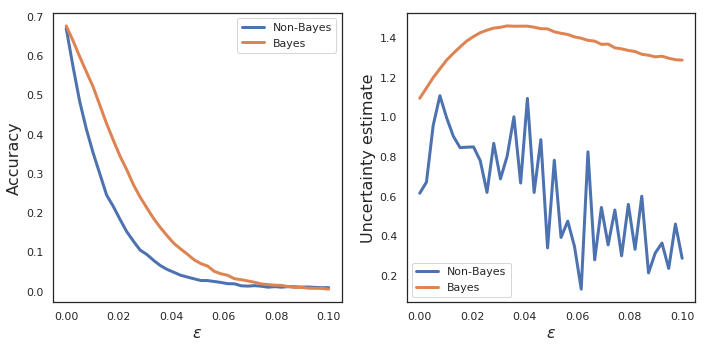

In [27]:
sns.set_style("white")
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc, linewidth=3)
plt.plot(epsilons,acc_bayes, linewidth=3)
plt.legend(['Non-Bayes','Bayes'])
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.subplot(1,2,2)
plt.plot(epsilons,entropies, linewidth=3)
plt.plot(epsilons,entropies_bayes, linewidth=3)
plt.legend(['Non-Bayes','Bayes'])
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.ylabel('Uncertainty estimate', fontsize=16)
fig.tight_layout()
plt.savefig('{}_adv_attack.png'.format(dataset))
plt.show()